In [70]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt

In [71]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [72]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [73]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [74]:
ticker='TSLA'

In [75]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [76]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [77]:
dates = pd.to_datetime(df['Date'])

In [78]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [79]:
df_for_training = df[cols].astype(float)

In [80]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [81]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [82]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [83]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [84]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [85]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [86]:
def build_model(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(Bidirectional(LSTM(hp_units,activation='relu',input_shape=(X.shape[1],X.shape[2]),return_sequences=False)))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [87]:
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='bi_lstm_tuning',
                     )

Reloading Tuner from ./bi_lstm_tuning/tuner0.json


In [88]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])

In [89]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 184.



In [90]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def forecast_bias(y_true, y_pred):
    return 100 * (np.mean(y_pred) - np.mean(y_true)) / np.mean(y_true)

Epoch 1/1000


3/3 [==============================] - 1s 87ms/step - loss: 0.0257 - val_loss: 0.0831
Epoch 2/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0171 - val_loss: 0.0657
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0106 - val_loss: 0.0509
Epoch 4/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0063 - val_loss: 0.0388
Epoch 5/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0294
Epoch 6/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0226
Epoch 7/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0029 - val_loss: 0.0181
Epoch 8/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0154
Epoch 9/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 10/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.0037 - val_loss: 0.0139
Epoch 11/1000
3/3 [===

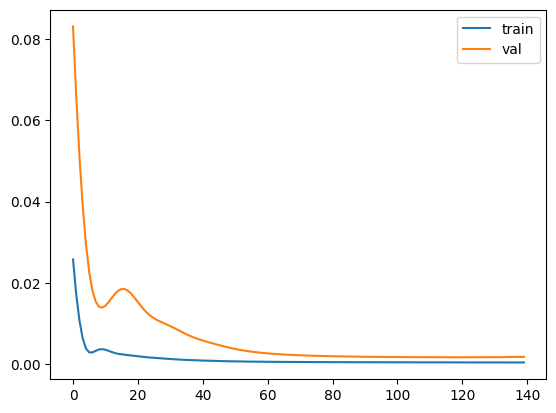

4/4 [==============================] - 0s 3ms/step
train mae: 0.903347752137851
val mae: 0.6685336999365233
train smape: 5.65846261777065
val smape: 3.8740706694595803
train forecast bias: 3.110453880103465
val forecast bias: 3.7635465297576136


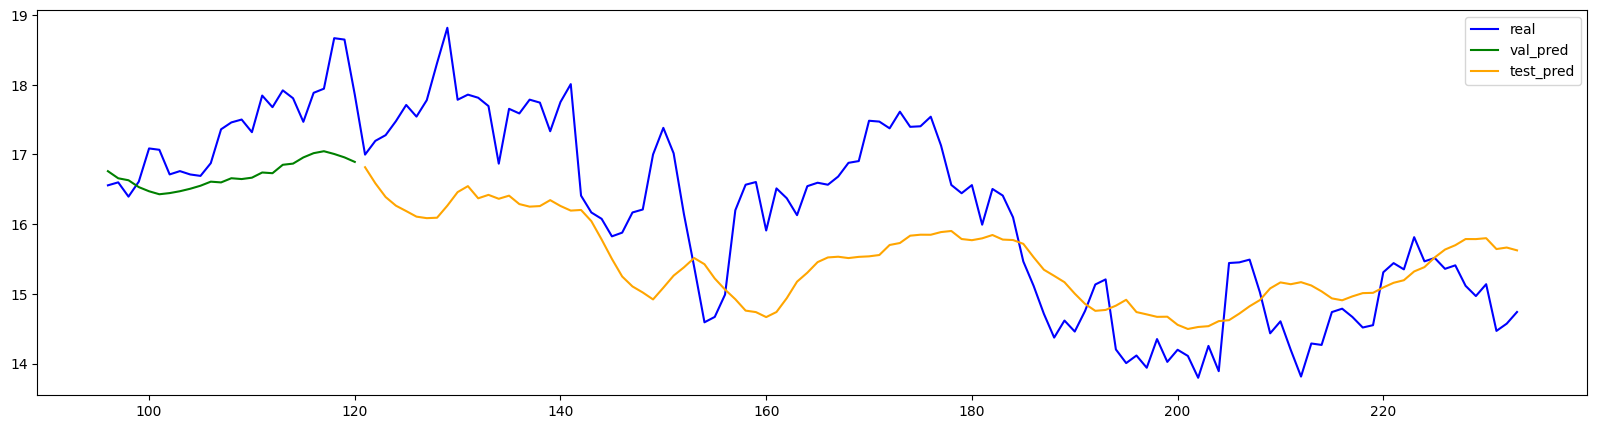

Epoch 1/1000
6/6 [==============================] - 1s 50ms/step - loss: 0.0658 - val_loss: 0.0354
Epoch 2/1000
6/6 [==============================] - 0s 29ms/step - loss: 0.0439 - val_loss: 0.0204
Epoch 3/1000
6/6 [==============================] - 0s 28ms/step - loss: 0.0273 - val_loss: 0.0100
Epoch 4/1000
6/6 [==============================] - 0s 27ms/step - loss: 0.0159 - val_loss: 0.0037
Epoch 5/1000
6/6 [==============================] - 0s 26ms/step - loss: 0.0090 - val_loss: 0.0010
Epoch 6/1000
6/6 [==============================] - 0s 27ms/step - loss: 0.0058 - val_loss: 7.4710e-04
Epoch 7/1000
6/6 [==============================] - 0s 28ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 8/1000
6/6 [==============================] - 0s 28ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 9/1000
6/6 [==============================] - 0s 36ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 10/1000
6/6 [==============================] - 0s 30ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch

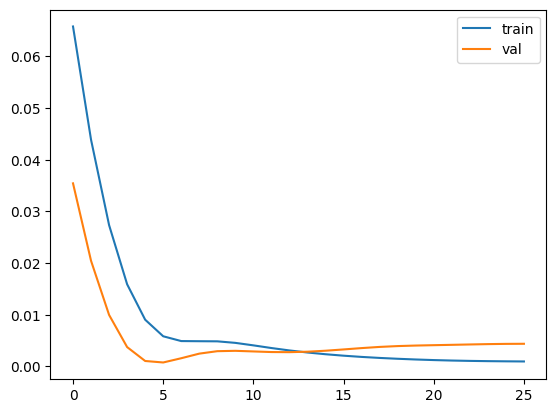

4/4 [==============================] - 0s 8ms/step
train mae: 1.369402715589135
val mae: 1.160483312202616
train smape: 9.79947150574558
val smape: 7.617639661648525
train forecast bias: -7.394247284700938
val forecast bias: -7.25660497120828


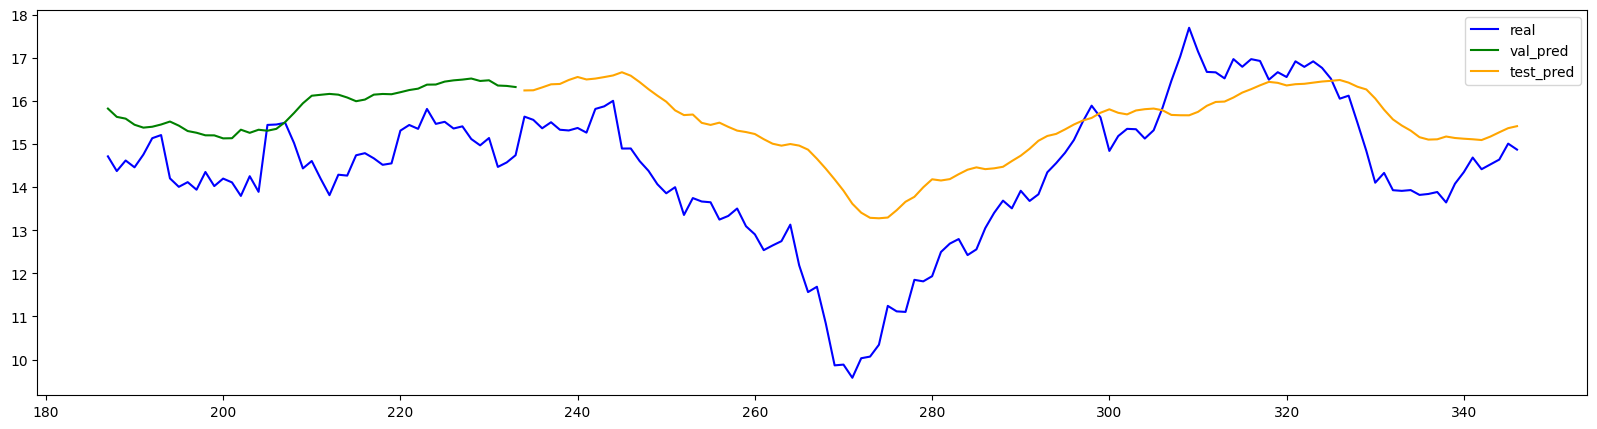

Epoch 1/1000
9/9 [==============================] - 1s 48ms/step - loss: 0.1089 - val_loss: 0.0700
Epoch 2/1000
9/9 [==============================] - 0s 31ms/step - loss: 0.0612 - val_loss: 0.0383
Epoch 3/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0308 - val_loss: 0.0186
Epoch 4/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.0139 - val_loss: 0.0087
Epoch 5/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 6/1000
9/9 [==============================] - 0s 31ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 7/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 8/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 9/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/1000
9/9 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 11/

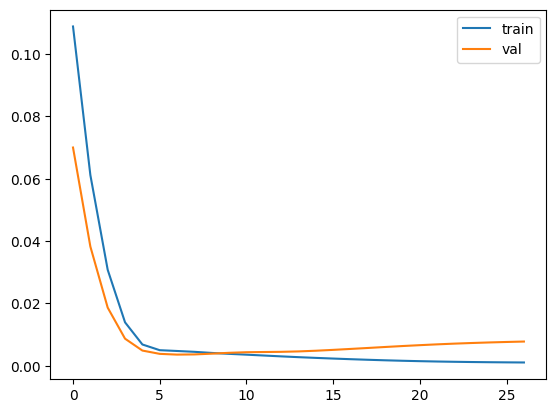

4/4 [==============================] - 0s 6ms/step
train mae: 1.824399561384083
val mae: 1.539979725359235
train smape: 13.64199570784499
val smape: 10.706229243535004
train forecast bias: 14.79345516393669
val forecast bias: 11.512819719249029


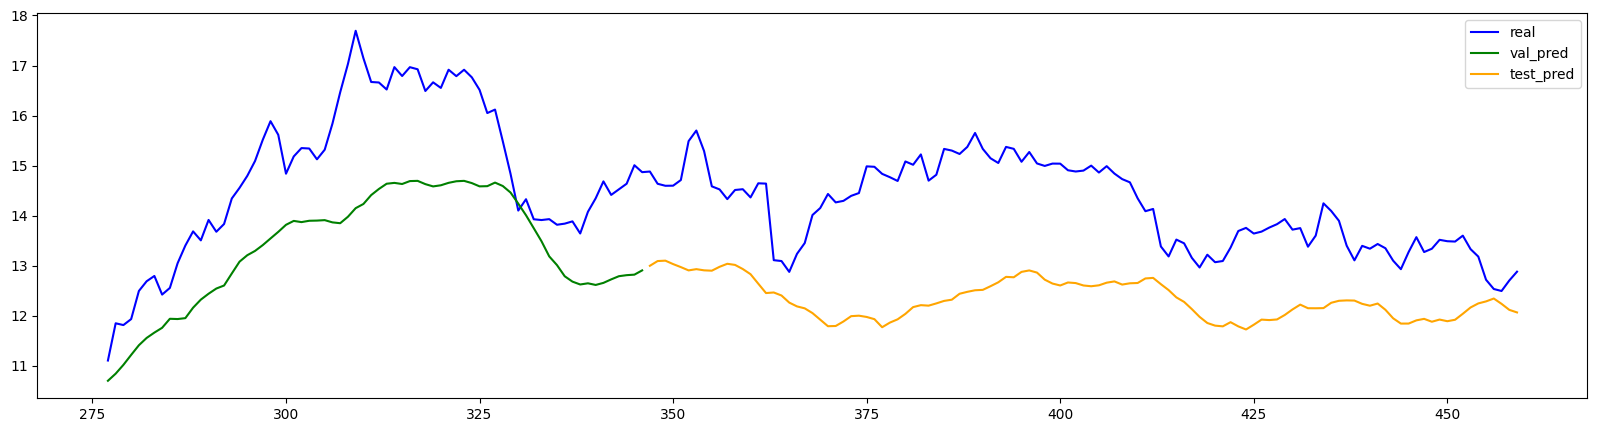

Epoch 1/1000
12/12 [==============================] - 1s 39ms/step - loss: 0.0763 - val_loss: 0.0265
Epoch 2/1000
12/12 [==============================] - 0s 26ms/step - loss: 0.0305 - val_loss: 0.0063
Epoch 3/1000
12/12 [==============================] - 0s 26ms/step - loss: 0.0118 - val_loss: 0.0024
Epoch 4/1000
12/12 [==============================] - 0s 27ms/step - loss: 0.0075 - val_loss: 0.0034
Epoch 5/1000
12/12 [==============================] - 0s 29ms/step - loss: 0.0071 - val_loss: 0.0035
Epoch 6/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0066 - val_loss: 0.0028
Epoch 7/1000
12/12 [==============================] - 0s 27ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 8/1000
12/12 [==============================] - 0s 26ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 9/1000
12/12 [==============================] - 0s 26ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 10/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.0047 - val_lo

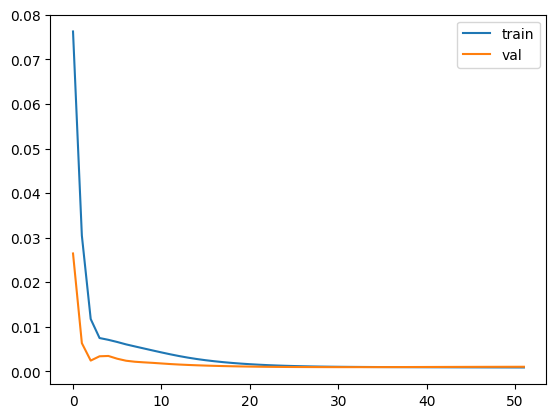

4/4 [==============================] - 0s 10ms/step
train mae: 0.7296736162368641
val mae: 0.4991669622543998
train smape: 4.442367804886752
val smape: 3.5612579170344105
train forecast bias: 3.8451557730500325
val forecast bias: 0.12339968434905525


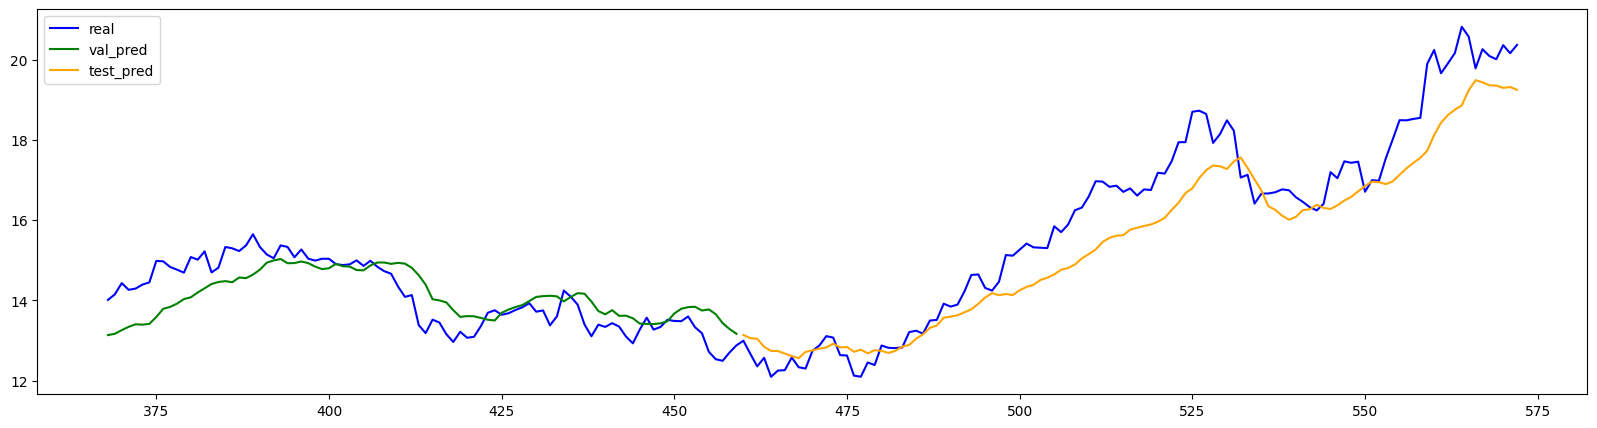

Epoch 1/1000
15/15 [==============================] - 2s 36ms/step - loss: 0.0506 - val_loss: 0.0334
Epoch 2/1000
15/15 [==============================] - 0s 28ms/step - loss: 0.0130 - val_loss: 0.0105
Epoch 3/1000
15/15 [==============================] - 0s 29ms/step - loss: 0.0061 - val_loss: 0.0091
Epoch 4/1000
15/15 [==============================] - 0s 29ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 5/1000
15/15 [==============================] - 0s 29ms/step - loss: 0.0041 - val_loss: 0.0102
Epoch 6/1000
15/15 [==============================] - 0s 29ms/step - loss: 0.0037 - val_loss: 0.0096
Epoch 7/1000
15/15 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 8/1000
15/15 [==============================] - 0s 27ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 9/1000
15/15 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0079
Epoch 10/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.0021 - val_lo

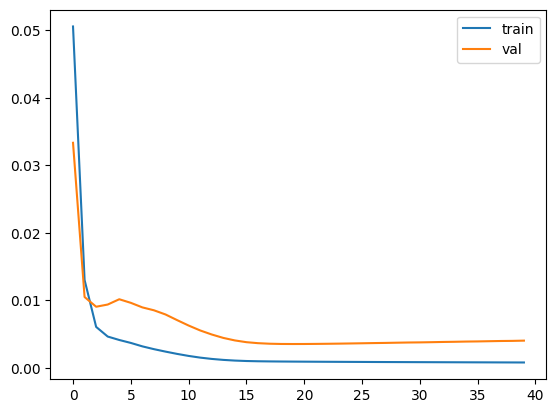

4/4 [==============================] - 0s 9ms/step
train mae: 1.9260258748487626
val mae: 1.0415646219482422
train smape: 8.706875724965796
val smape: 6.498507181171807
train forecast bias: 9.00064240575414
val forecast bias: 6.6201555165675545


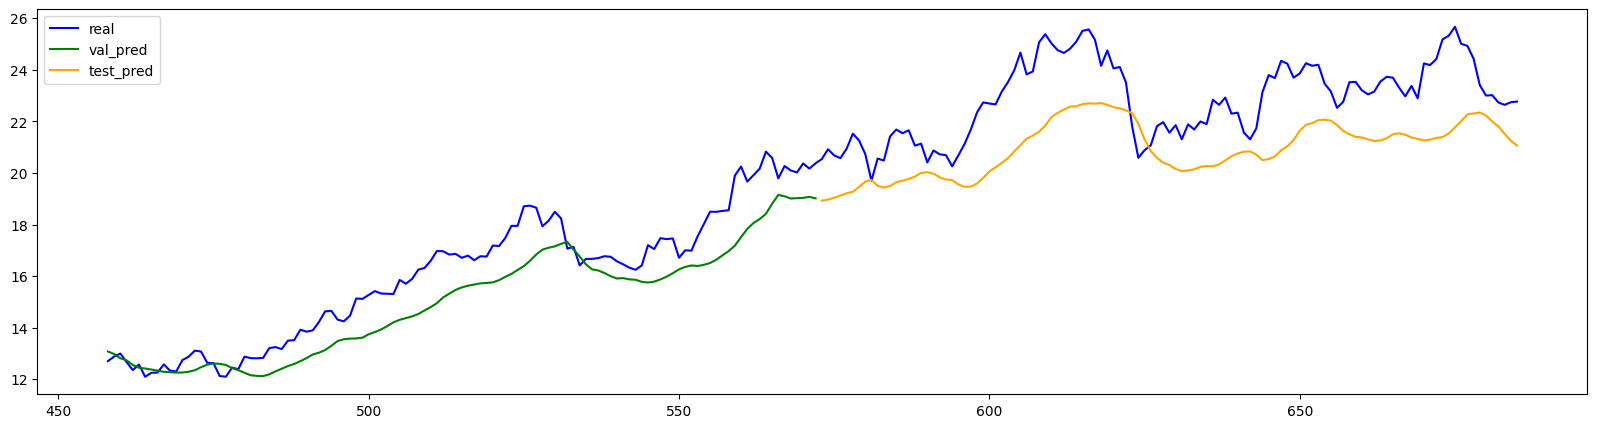

Epoch 1/1000
18/18 [==============================] - 2s 33ms/step - loss: 0.0632 - val_loss: 0.2401
Epoch 2/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.0126 - val_loss: 0.0939
Epoch 3/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.0051 - val_loss: 0.0566
Epoch 4/1000
18/18 [==============================] - 0s 28ms/step - loss: 0.0048 - val_loss: 0.0581
Epoch 5/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.0042 - val_loss: 0.0571
Epoch 6/1000
18/18 [==============================] - 0s 24ms/step - loss: 0.0037 - val_loss: 0.0494
Epoch 7/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 0.0423
Epoch 8/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.0029 - val_loss: 0.0364
Epoch 9/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.0025 - val_loss: 0.0302
Epoch 10/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.0021 - val_lo

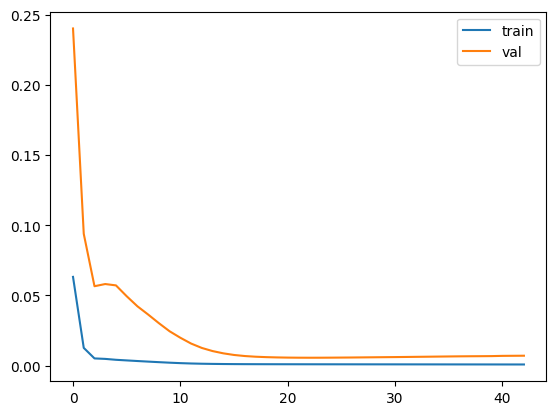

4/4 [==============================] - 0s 10ms/step
train mae: 0.9647256843283322
val mae: 1.362296717387766
train smape: 4.414600921370713
val smape: 6.15360551897465
train forecast bias: 4.084428805934723
val forecast bias: 6.075352005807108


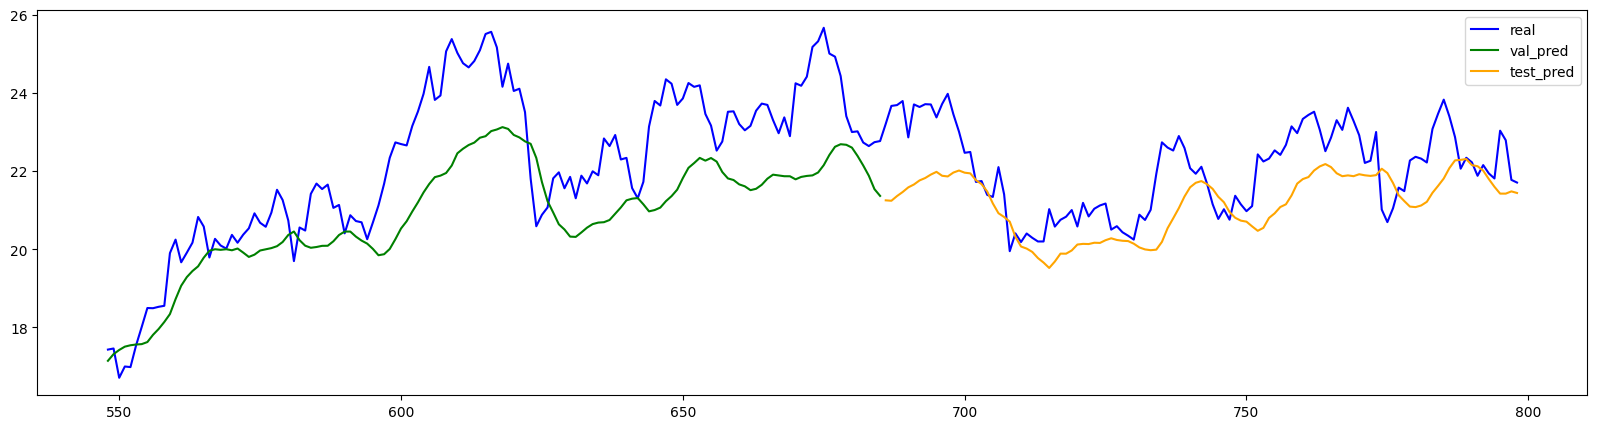

Epoch 1/1000
20/20 [==============================] - 2s 33ms/step - loss: 0.0702 - val_loss: 0.1427
Epoch 2/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0126 - val_loss: 0.0324
Epoch 3/1000
20/20 [==============================] - 1s 27ms/step - loss: 0.0089 - val_loss: 0.0170
Epoch 4/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.0070 - val_loss: 0.0149
Epoch 5/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 6/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 7/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 8/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.0024 - val_loss: 0.0058
Epoch 9/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.0021 - val_loss: 0.0073
Epoch 10/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.0018 - val_lo

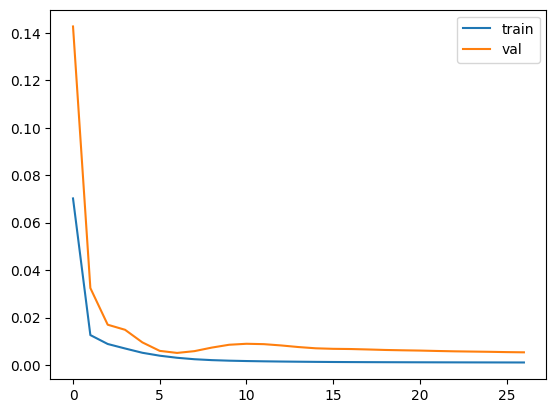

4/4 [==============================] - 0s 3ms/step
train mae: 2.2442799964632023
val mae: 1.1399634002540586
train smape: 10.460993224051892
val smape: 4.988191915983156
train forecast bias: -9.33422976221073
val forecast bias: -3.7449368012980786


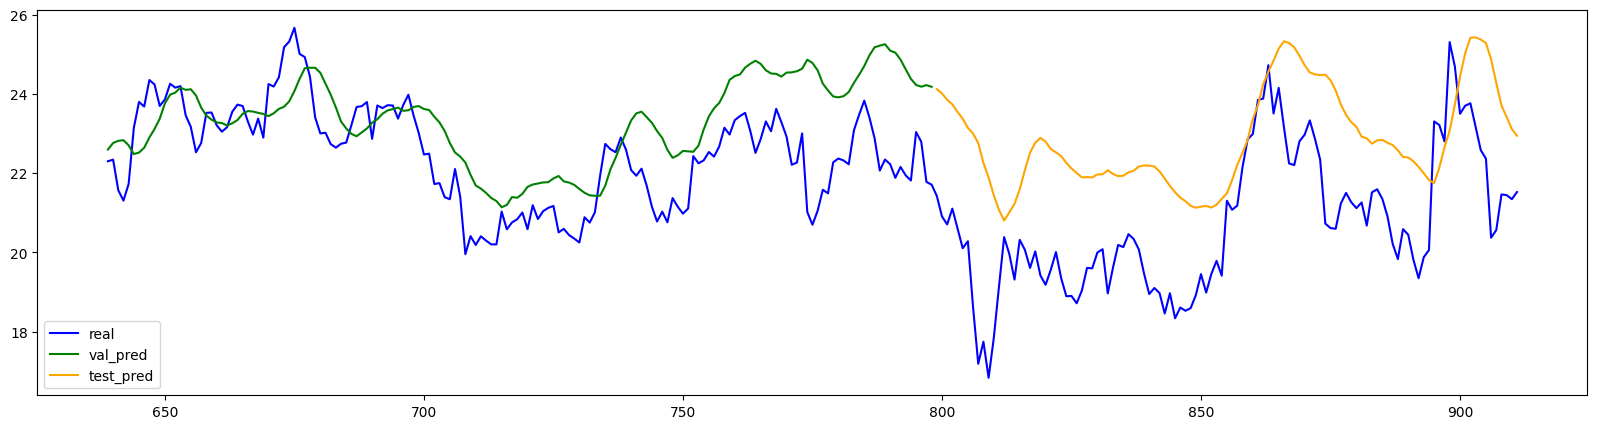

Epoch 1/1000
23/23 [==============================] - 2s 34ms/step - loss: 0.0935 - val_loss: 0.0471
Epoch 2/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.0100 - val_loss: 0.0129
Epoch 3/1000
23/23 [==============================] - 1s 29ms/step - loss: 0.0066 - val_loss: 0.0234
Epoch 4/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.0047 - val_loss: 0.0214
Epoch 5/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.0035 - val_loss: 0.0272
Epoch 6/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.0028 - val_loss: 0.0308
Epoch 7/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.0023 - val_loss: 0.0320
Epoch 8/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.0020 - val_loss: 0.0316
Epoch 9/1000
23/23 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 0.0299
Epoch 10/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.0018 - val_lo

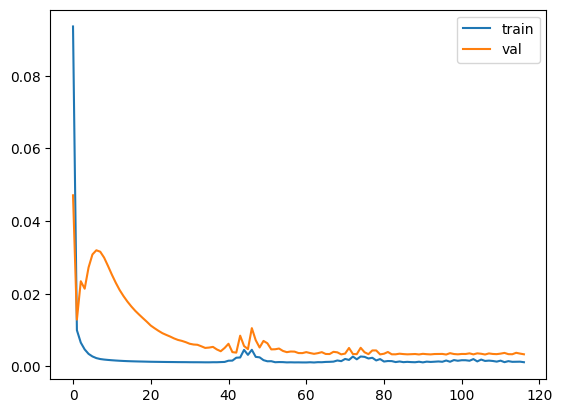

4/4 [==============================] - 0s 10ms/step
train mae: 1.1859692558690975
val mae: 0.8336465343778016
train smape: 5.695066220961937
val smape: 3.9343638666794414
train forecast bias: 3.540713497541046
val forecast bias: -0.010306310449664983


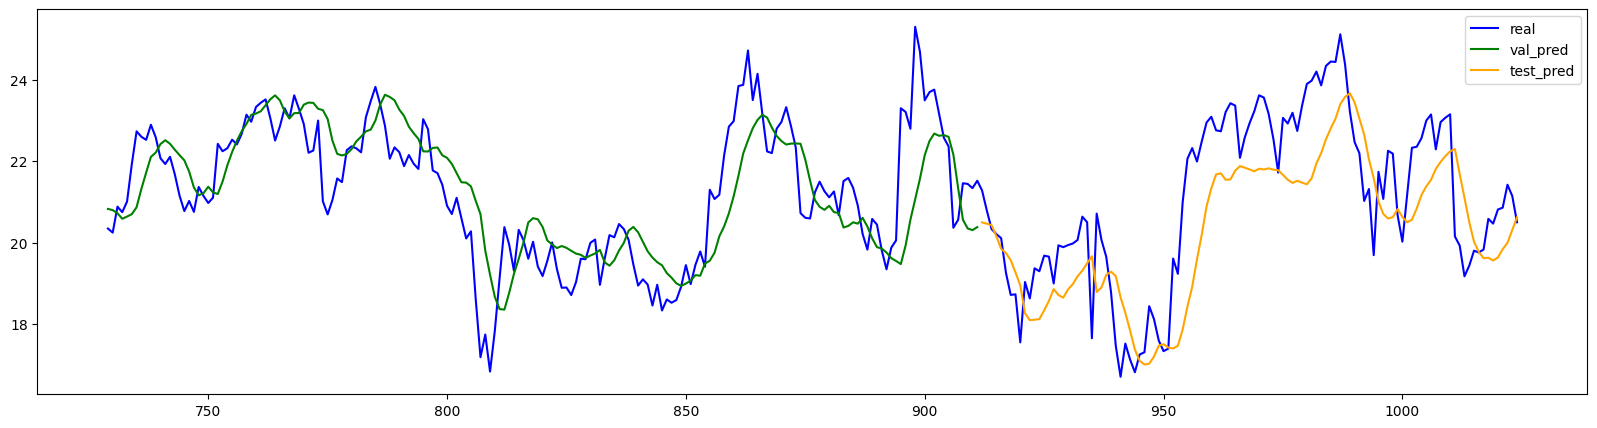

Epoch 1/1000
26/26 [==============================] - 2s 32ms/step - loss: 0.0592 - val_loss: 0.0067
Epoch 2/1000
26/26 [==============================] - 1s 27ms/step - loss: 0.0090 - val_loss: 0.0490
Epoch 3/1000
26/26 [==============================] - 1s 28ms/step - loss: 0.0066 - val_loss: 0.0270
Epoch 4/1000
26/26 [==============================] - 1s 26ms/step - loss: 0.0052 - val_loss: 0.0262
Epoch 5/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0041 - val_loss: 0.0223
Epoch 6/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0033 - val_loss: 0.0180
Epoch 7/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0026 - val_loss: 0.0141
Epoch 8/1000
26/26 [==============================] - 1s 24ms/step - loss: 0.0021 - val_loss: 0.0109
Epoch 9/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0018 - val_loss: 0.0086
Epoch 10/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0017 - val_lo

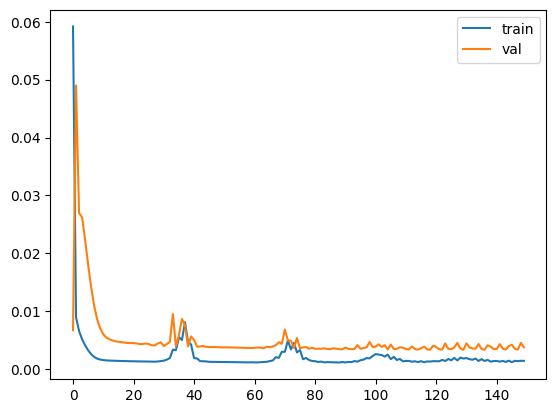

4/4 [==============================] - 0s 9ms/step
train mae: 1.6023294147598133
val mae: 0.9193045313470609
train smape: 9.768984944561037
val smape: 4.3902793631470605
train forecast bias: -8.253771126434305
val forecast bias: 1.445013658247082


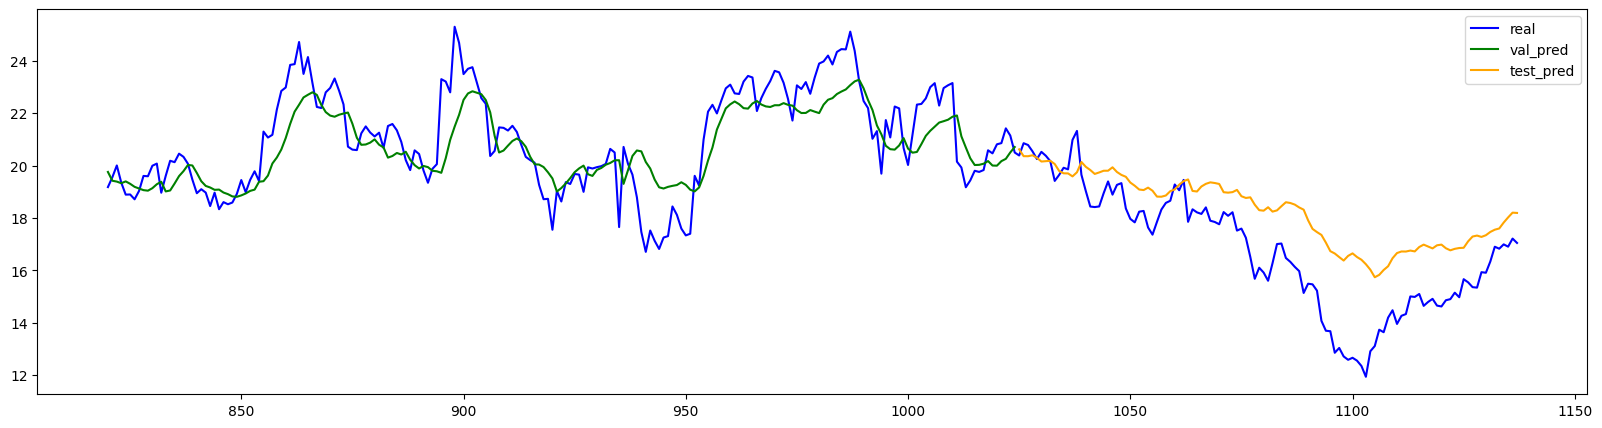

Epoch 1/1000
29/29 [==============================] - 3s 35ms/step - loss: 0.1550 - val_loss: 0.0785
Epoch 2/1000
29/29 [==============================] - 1s 27ms/step - loss: 0.0121 - val_loss: 0.0195
Epoch 3/1000
29/29 [==============================] - 1s 28ms/step - loss: 0.0092 - val_loss: 0.0284
Epoch 4/1000
29/29 [==============================] - 1s 29ms/step - loss: 0.0074 - val_loss: 0.0244
Epoch 5/1000
29/29 [==============================] - 1s 27ms/step - loss: 0.0057 - val_loss: 0.0247
Epoch 6/1000
29/29 [==============================] - 1s 27ms/step - loss: 0.0046 - val_loss: 0.0222
Epoch 7/1000
29/29 [==============================] - 1s 28ms/step - loss: 0.0039 - val_loss: 0.0190
Epoch 8/1000
29/29 [==============================] - 1s 27ms/step - loss: 0.0033 - val_loss: 0.0160
Epoch 9/1000
29/29 [==============================] - 1s 27ms/step - loss: 0.0029 - val_loss: 0.0134
Epoch 10/1000
29/29 [==============================] - 1s 29ms/step - loss: 0.0026 - val_lo

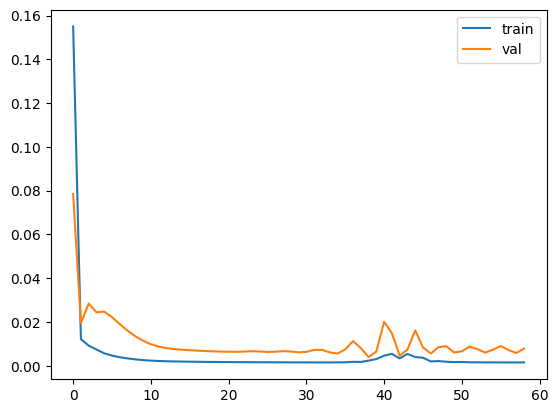

4/4 [==============================] - 0s 3ms/step
train mae: 1.5739250278752421
val mae: 1.4041516310636288
train smape: 8.755521141062742
val smape: 7.799657363904264
train forecast bias: -5.978225305685747
val forecast bias: -5.421023544760656


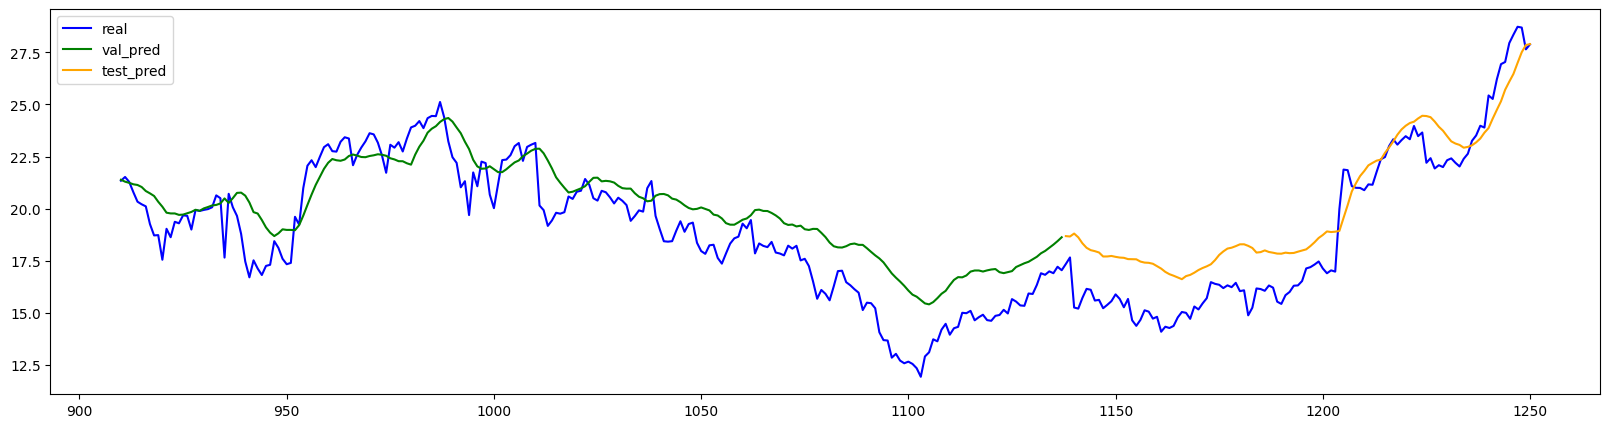

In [91]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
t_smapes=[]
v_smapes=[]
t_forecast_biases=[]
v_forecast_biases=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=mae(pred,y_test)
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=mae(val_pred,y_val)
    v_maes.append(v_mae)
    print('val mae:',v_mae)
    t_smape=smape(pred,y_test)
    t_smapes.append(t_smape)
    print('train smape:',t_smape)
    v_smape=smape(val_pred,y_val)
    v_smapes.append(v_smape)
    print('val smape:',v_smape)
    t_forecast_bias=forecast_bias(pred,y_test)
    t_forecast_biases.append(t_forecast_bias)
    print('train forecast bias:',t_forecast_bias)
    v_forecast_bias=forecast_bias(val_pred,y_val)
    v_forecast_biases.append(v_forecast_bias)
    print('val forecast bias:',v_forecast_bias)
    

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()

In [92]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_37 (Bidirect  (None, 368)               297344    
 ional)                                                          
                                                                 
 dense_37 (Dense)            (None, 1)                 369       
                                                                 
Total params: 297713 (1.14 MB)
Trainable params: 297713 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Taverage_smape=np.mean(t_smapes)

print('Average SMAPE in testing:',Taverage_smape)

Vaverage_smape=np.mean(v_smapes)

print('Average SMAPE in validation:',Vaverage_smape)


Taverage_forecast_bias=np.mean(t_forecast_biases)

print('Average forecast bias in testing:',Taverage_forecast_bias)

Vaverage_forecast_bias=np.mean(v_forecast_biases)

print('Average forecast bias in validation:',Vaverage_forecast_bias)

Average MAE in testing: 1.4324078899492385
Average MAE in validation: 1.0569091136131332
Average SMAPE in testing: 8.134433981322209
Average SMAPE in validation: 5.95238027015379
Average forecast bias in testing: 0.7414376047288375
Average forecast bias in validation: 1.310741548626076
